In [63]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Predict pneumothorax vs no finding 

This project started with trying to recreate the ChestXNet project. Briefly explained, the ChestXNet group has developed an algorithm to classify pneumonia from other thoracic diseases in the ChestX-ray14 data set released by Wang et al. (2017). This data set contains of 112,120 frontal-view chest X-ray images, where each of them are labeled with up to 14 different diseases. You can read more about the CheXNet here: https://stanfordmlgroup.github.io/projects/chexnet/
<br>

Some of the issues I encountered along the way with this paper was that they have not described how they have balanced pneumonia in relation to all other diseases, how they have handled image of the same patient in the training and the validation sets, and how their test set looks like.
<br>

Therefore, it has been difficult for me to compare this project with theirs.
The purpose of recreating their project was to use a trained network on chest X ray14 data set to train another x-ray data set and look into the value of transfer learning.
To achieve a well trained network on chestX-ray 14 data set we have decided to look into another disease with more unique examples in the dataset compared with pneumonia.

In [64]:
import sys
sys.path.append("../../fastai/")

In [65]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

In [66]:
PATH = "/home/sathiesh/Deep_Learning_Kaliy/my_projects/chest-xrays/data/"  #MMIV
#PATH = "/Users/Sathiesh/MachineLearning/Deep_Learning_Kaliy/my_projects/chest-xrays/data/" #Home

In [67]:
sz=64
arch=dn121 #bytt denne til 121 igjen 
bs = 16

In [68]:
label_csv = f'{PATH}Data_Entry_2017.csv' 

In [69]:
os.listdir(PATH)

['models',
 'tmp',
 'train',
 'train_contrast',
 'test',
 'Data_Entry_2017.csv',
 'test_list.txt',
 'cleaned_labels']

In [70]:
df = pd.read_csv(label_csv)

# Feature engineering and data cleaning 

Below is a brief information about the required columns from the dataset:
- ###### Image Index: The name of an image
- ###### Finding Labels: Shows the disease(s) 

In [71]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalHeight,OriginalImagePixelSpacingx,OriginalImagePixelSpacingy,Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [72]:
df = df.drop(['Follow-up #','Patient ID', 'Patient Age', 'Patient Gender', 'View Position',
              'OriginalImageWidth', 'OriginalHeight', 'OriginalImagePixelSpacingx', 'OriginalImagePixelSpacingy', 'Unnamed: 11'],axis=1)
df.head()

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_000.png,Hernia


## Top 10 diseases in the dataset


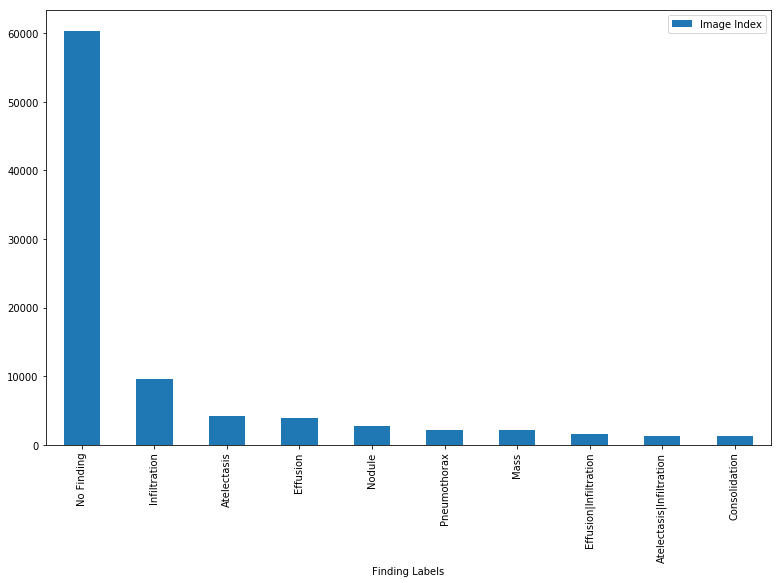

In [73]:
df_sorted = df.pivot_table(index='Finding Labels', aggfunc=len).sort_values('Image Index', ascending=False) 
df_sorted[0:10].plot(kind='bar',figsize=(13,8))

In [74]:
df_sorted.head(10)

,Image Index
Finding Labels,
No Finding,60361
Infiltration,9547
Atelectasis,4215
Effusion,3955
Nodule,2705
Pneumothorax,2194
Mass,2139
Effusion|Infiltration,1603
Atelectasis|Infiltration,1350


## Analyzing a specific disease
If this returns true, then skip to <i> view data</i> section

In [75]:
disease_name = 'Pneumothorax'
cleaned_label_path = f'{PATH}cleaned_labels/{disease_name}.csv' 
exists = os.path.exists(cleaned_label_path)
if(False): 
    df = pd.read_csv(cleaned_label_path)
print('If exists equals true, then skip to view data section')
print('exists = ' + str(exists))

If exists equals true, then skip to view data section
exists = True


In [76]:
df_disease = df_sorted[df_sorted.index.str.contains(disease_name)]
disease_row = df_sorted.loc[disease_name]['Image Index']
total_apperance = sum(df_disease['Image Index'])
print(disease_name +': ' + str(disease_row) + '\n'+ 'Total apperance: ' + str(total_apperance))

Pneumothorax: 2194
Total apperance: 5302


In [77]:
df.shape

(112120, 2)

In [78]:
df['searching_disease'] = df['Finding Labels'].str.contains(disease_name)
no_finding_idxs =  list(df.loc[df['Finding Labels'] == 'No Finding'].index)
searching_disease_idxs = list(df[df['searching_disease']].index) #all rows with disease_name 

In [79]:
arr = np.concatenate((no_finding_idxs, searching_disease_idxs))

In [80]:
df = df.iloc[df.index.get_indexer(arr)]

In [81]:
df.head()

,Image Index,Finding Labels,searching_disease
3,00000002_000.png,No Finding,False
13,00000005_000.png,No Finding,False
14,00000005_001.png,No Finding,False
15,00000005_002.png,No Finding,False
16,00000005_003.png,No Finding,False


In [82]:
df.shape

(65663, 3)

In [21]:
#her henter jeg test filen og tar ut alle bildene som skal være i test filen 

In [83]:
test_image_name_list = [line.rstrip('\n') for line in open(f'{PATH}test_list.txt')]
len(test_image_name_list)

25596

In [84]:
test_dic = {}
for img_name in test_image_name_list: 
    img_row = df.loc[df['Image Index'] == img_name]
    if not img_row.empty: 
        test_dic[img_name] = bool(img_row.searching_disease.values)
        pos = int(img_row.index.values)
        df = df.drop([pos])

In [85]:
len(test_dic)

12526

In [86]:
df = df.reset_index(drop=True)

In [87]:
df.shape

(53137, 3)

### Ratio
Find the ratio to balance the data

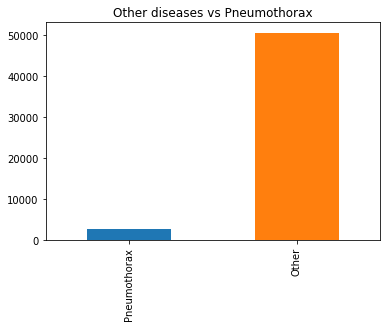

In [88]:
df_sorted = df.pivot_table(index='searching_disease', aggfunc=len).sort_values('Image Index') 
df_sorted.index = [disease_name,'Other']
df_sorted['Image Index'].plot(kind='bar', title="Other diseases vs "+disease_name)

In [89]:
df_sorted

,Finding Labels,Image Index
Pneumothorax,2637,2637
Other,50500,50500


In [90]:
disease_count = df_sorted['Image Index'][0]
other_disease_count = df_sorted['Image Index'][1]
ratio = (other_disease_count// disease_count)-1
df = df.append([df[df.searching_disease]]*ratio, ignore_index=True) #df.searching_disease: array m true, false 
ratio

18

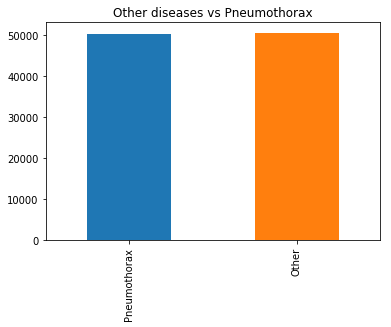

In [91]:
df_sorted = df.pivot_table(index='searching_disease', aggfunc=len).sort_values('Image Index') 
df_sorted.index = [disease_name,'Other']
df_sorted['Image Index'].plot(kind='bar', title="Other diseases vs "+disease_name)

In [92]:
df = df.drop(['Finding Labels'], axis=1)

In [93]:
df.head()

,Image Index,searching_disease
0,00000002_000.png,False
1,00000005_000.png,False
2,00000005_001.png,False
3,00000005_002.png,False
4,00000005_003.png,False


In [94]:
cleaned_label_path = f'{PATH}cleaned_labels/{disease_name}.csv'
df.to_csv(cleaned_label_path, index=False)

In [95]:
with open(f'{PATH}cleaned_labels/{disease_name}_test_fil.csv','w') as f:
    w = csv.writer(f)
    w.writerows(test_dic.items())

# View data 
The validation set we create with the training set may contain images of the same patient as there are several images of a patient. This may lead to better results on the validation set than on test set. 
Since we want a well trained network on chestX-ray 14 data set to look into the value of transfer learning, we have decided to use the test set as the validation set. 

In [ ]:
#move all the files from test folder back to train folder (the test images can be for another disease)
%load move_from_test_to_train.py

In [ ]:
#move test images from the train folder to test folder
from move_files_from_train_to_test import * 

df_test = pd.read_csv(f'{PATH}cleaned_labels/{disease_name}_test_fil.csv', header=None)
df_test.columns = ['Image Index', 'searching_disease']
move_to_test(df_test)

In [96]:
def get_data(sz): 
    tfms = tfms_from_model(arch, sz, aug_tfms=RandomFlip())
    return ImageClassifierData.from_csv(PATH, 'train', cleaned_label_path, test_name="test" , tfms=tfms, bs=bs);

In [97]:
data = get_data(sz)

In [98]:
data.trn_ds.fnames.shape ,data.val_ds.fnames.shape, len(data.test_ds.fnames)

((80483,), (20120,), 12526)

In [99]:
data.classes[:2]

['False', 'True']

# Training

In [100]:
learn = ConvLearner.pretrained(arch, data, opt_fn=optim.Adam, ps=0.2)

In [40]:
learn.lr_find()

 64%|██████▍   | 3212/5031 [09:01<05:06,  5.93it/s, loss=2.34] 

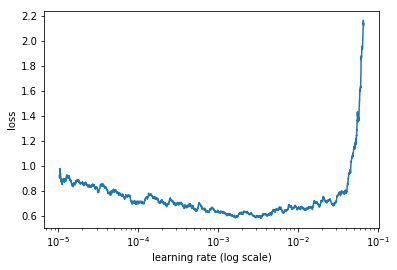

 64%|██████▍   | 3212/5031 [09:10<05:11,  5.84it/s, loss=2.34]

In [41]:
learn.sched.plot()

In [101]:
lr = 0.0001

In [102]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.614594   0.5172     0.745229  
    1      0.543672   0.498779   0.763668                      
    2      0.528664   0.495341   0.763817                      
    3      0.533707   0.48502    0.774553                      
    4      0.517043   0.471058   0.788221                      
    5      0.490096   0.461302   0.795179                      
    6      0.501633   0.46       0.79503                       



[array([0.46]), 0.7950298210735587]

In [ ]:
#learn.lr_find()
#learn.sched.plot()

In [110]:
learn.unfreeze()

In [111]:
lrs = [lr/9, lr/3,lr];

In [112]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.429265   0.347603   0.865358  
    1      0.268057   0.227473   0.915606                      



[array([0.22747]), 0.9156063618290259]

In [113]:
learn.save(f'{sz}121{disease_name}') 

In [114]:
sz=128
learn.set_data(get_data(sz))
learn.freeze() 

In [115]:
#learn.lr_find()
#learn.sched.plot()

In [116]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2) 

epoch      trn_loss   val_loss   accuracy                      
    0      0.542983   0.509307   0.760139  
    1      0.52912    0.472684   0.782903                      
    2      0.513544   0.462858   0.79165                       
    3      0.50402    0.439959   0.812972                      
    4      0.473981   0.418157   0.819384                      
    5      0.467682   0.408964   0.827684                      
    6      0.455107   0.405959   0.831461                      



[array([0.40596]), 0.8314612326043738]

In [117]:
learn.unfreeze()

In [118]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)  #sette epoch verdi ned til 2 kanskje 

epoch      trn_loss   val_loss   accuracy                      
    0      0.285853   0.232913   0.92172   



[array([0.23291]), 0.9217196819085487]

In [119]:
learn.save(f'{sz}169{disease_name}')

In [120]:
sz = 256

In [121]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
#overfitter veldig når jeg kjører unfreeze

epoch      trn_loss   val_loss   accuracy                      
    0      0.519978   0.466882   0.790805  
    1      0.487558   0.437034   0.809195                      
    2      0.471819   0.422594   0.822068                      
    3      0.439835   0.399682   0.836879                      
    4      0.446583   0.377486   0.851889                      
    5      0.446863   0.370061   0.85661                       
    6      0.43548    0.369327   0.860239                      



[array([0.36933]), 0.8602385685884691]

In [122]:
learn.unfreeze()

In [123]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.249454   0.188792   0.944533  



[array([0.18879]), 0.9445328031809145]

In [124]:
learn.save(f'{sz}169{disease_name}')

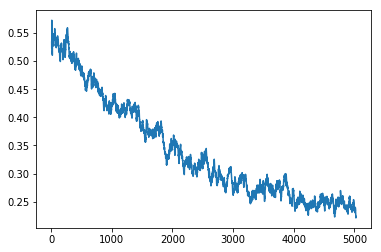

In [125]:
learn.sched.plot_loss()

#  Analyzing the results

In [126]:
df_test = pd.read_csv(f'{PATH}cleaned_labels/{disease_name}_test_fil.csv', header=None) #TODO slett denne, denne finnes lenger oppe

In [127]:
df_test.columns = ['Image Index', 'searching_disease']
df_test.head()

,Image Index,searching_disease
0,00000013_000.png,False
1,00000013_001.png,True
2,00000013_002.png,True
3,00000013_004.png,True
4,00000013_005.png,True


In [128]:
df_test.shape

(12526, 2)

In [129]:
data.test_ds.y[:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.]])

In [106]:
pos = 0
for i in data.test_ds.fnames: 
    img_name = i.replace("test/", "")
    img_row = df_test.loc[df_test['Image Index'] == img_name]
    
    if not img_row.empty:
        data.test_ds.y[pos] = float(img_row.searching_disease.values)
    pos +=1

In [130]:
data.test_ds.y[:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.]])

In [147]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),axis=0)
accuracy = accuracy_np(probs, y)

In [148]:
print('Accuracy with TTA: '+str(accuracy))

Accuracy with TTA: 0.64378093565384


In [149]:
preds = np.argmax(probs, axis=1)  #selects the position of the highest value
probs = probs[:,1] 

In [150]:
cm = confusion_matrix(y,preds);

[[8064 4462]
 [   0    0]]


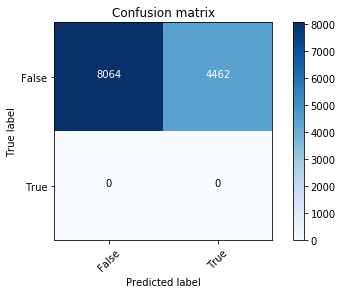

In [151]:
plot_confusion_matrix(cm, data.classes)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(y, preds)  

In [ ]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[val_idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [ ]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [ ]:
def load_img_id(ds, val_idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(val_idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in val_idxs]
    title_probs = [probs[x] for x in val_idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect effusion")